













# ***LSTM***

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
data = pd.read_csv('merged-file0.csv')

index=0
data.columns.values[index]='comment'
comments = data['comment']

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''

data['processed_comment'] = comments.apply(preprocess_text)

In [4]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = sia.polarity_scores(text)['compound']
    return 1 if score >= 0 else 0

data['label'] = data['processed_comment'].apply(get_sentiment_label)

max_words = 5000
max_len = 100

In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['processed_comment'])
sequences = tokenizer.texts_to_sequences(data['processed_comment'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

In [6]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
checkpoint = ModelCheckpoint('LSTM_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 370s 121ms/step - accuracy: 0.8682 - loss: 0.3398 - val_accuracy: 0.9455 - val_loss: 0.1700
Epoch 2/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 350s 117ms/step - accuracy: 0.9514 - loss: 0.1536 - val_accuracy: 0.9533 - val_loss: 0.1427
Epoch 3/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 390s 119ms/step - accuracy: 0.9641 - loss: 0.1198 - val_accuracy: 0.9562 - val_loss: 0.1397
Epoch 4/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 380s 119ms/step - accuracy: 0.9693 - loss: 0.1031 - val_accuracy: 0.9538 - val_loss: 0.1506
Epoch 5/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 354s 118ms/step - accuracy: 0.9738 - loss: 0.0875 - val_accuracy: 0.9514 - val_loss: 0.1577
Epoch 6/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 354s 118ms/step - accuracy: 0.9767 - loss: 0.0774 - val_accuracy: 0.9510 - val_loss: 0.1711
Epoch 7/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 407s 126ms/step - accuracy: 0.9802 - loss: 0.0676 - val_accuracy: 0.9490 - val_loss: 0.2022
Epoch 8/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 363s 120ms/step - ac

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

751/751 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.9562 - loss: 0.1387
Test Accuracy: 0.9562086462974548


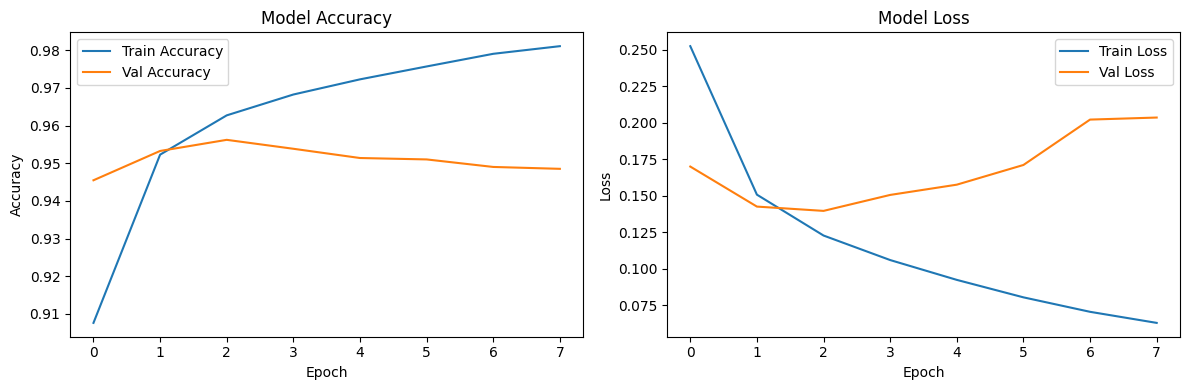

In [12]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [13]:
import tensorflow as tf
tf.saved_model.save(model, 'LSTM')
loaded_model = tf.saved_model.load('LSTM')


In [14]:
import shutil
shutil.make_archive('LSTM', 'zip', 'LSTM')
from google.colab import files
files.download('LSTM.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# def predict_sentiment(text):
#     processed_text = preprocess_text(text)
#     sequence = tokenizer.texts_to_sequences([processed_text])
#     padded_sequence = pad_sequences(sequence, maxlen=max_len)
#     prediction = model.predict(padded_sequence)
#     return 'Positive' if prediction >= 0.5 else 'Negative'

# print(predict_sentiment("This is a great product!"))
# print(predict_sentiment("I am very disappointed with this item."))

# ***RNN***

In [15]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
checkpoint = ModelCheckpoint('RNN_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 188s 62ms/step - accuracy: 0.8389 - loss: 0.3952 - val_accuracy: 0.9134 - val_loss: 0.2385
Epoch 2/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 200s 61ms/step - accuracy: 0.9070 - loss: 0.2541 - val_accuracy: 0.9193 - val_loss: 0.2471
Epoch 3/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 180s 60ms/step - accuracy: 0.9067 - loss: 0.2612 - val_accuracy: 0.9139 - val_loss: 0.2405
Epoch 4/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 179s 60ms/step - accuracy: 0.9221 - loss: 0.2264 - val_accuracy: 0.9316 - val_loss: 0.2177
Epoch 5/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 205s 61ms/step - accuracy: 0.9341 - loss: 0.2052 - val_accuracy: 0.9292 - val_loss: 0.2142
Epoch 6/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 201s 60ms/step - accuracy: 0.9407 - loss: 0.1923 - val_accuracy: 0.9236 - val_loss: 0.2200
Epoch 7/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 179s 60ms/step - accuracy: 0.9402 - loss: 0.1919 - val_accuracy: 0.9214 - val_loss: 0.2223
Epoch 8/50
3003/3003 ━━━━━━━━━━━━━━━━━━━━ 203s 60ms/step - accuracy: 

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

751/751 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9366 - loss: 0.1996
Test Accuracy: 0.9366440773010254


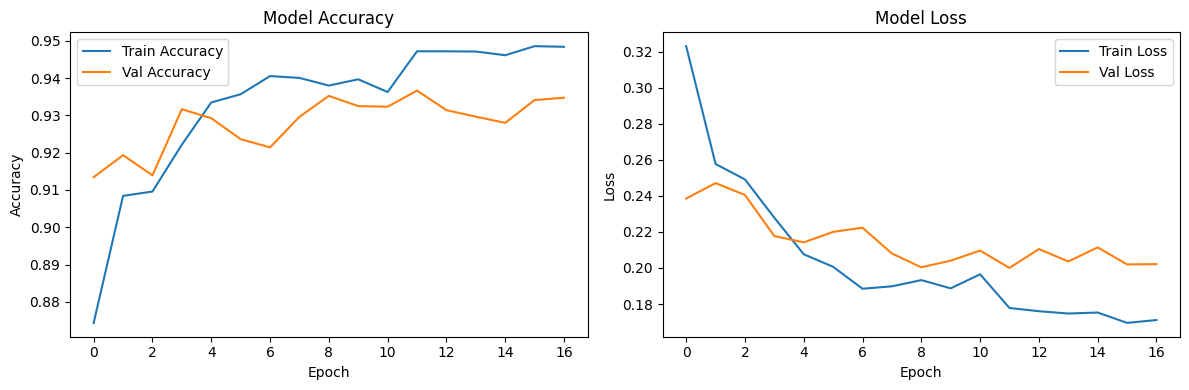

In [18]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [19]:
import tensorflow as tf
tf.saved_model.save(model, 'RNN')
loaded_model = tf.saved_model.load('RNN')


# ***HYBRID***

In [ ]:
# # RNN
# from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
# model.add(SimpleRNN(64, return_sequences=True))
# model.add(Dropout(0.5))
# # LSTM
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(SimpleRNN(64))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# # model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy}')

In [ ]:
# model.save('Hybrid.h5')
# model.save('Hybrid.keras')

751/751 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


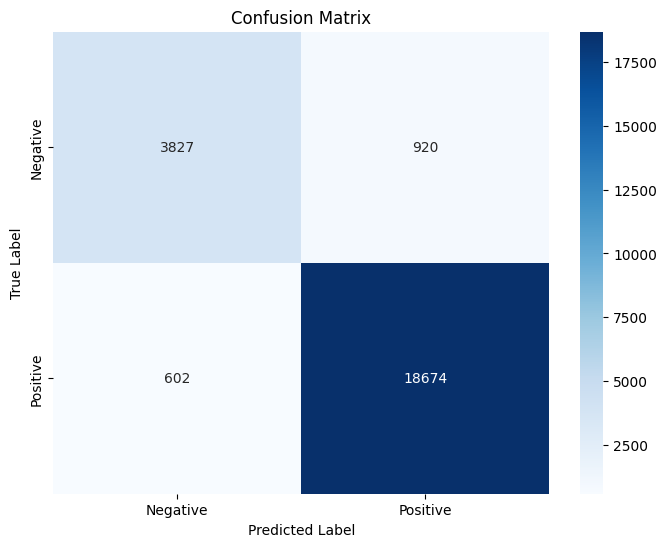

              precision    recall  f1-score   support

    Negative       0.86      0.81      0.83      4747
    Positive       0.95      0.97      0.96     19276

    accuracy                           0.94     24023
   macro avg       0.91      0.89      0.90     24023
weighted avg       0.94      0.94      0.94     24023



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



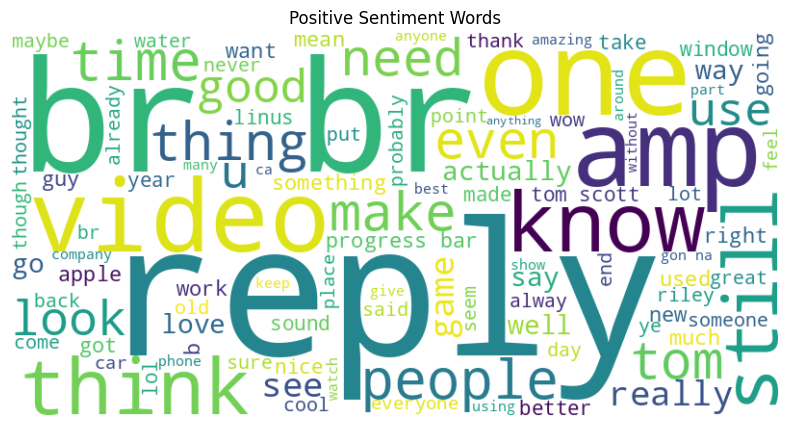

In [22]:
# Text Visualization using Word Clouds for Positive and Negative classes
def generate_word_cloud(data, label, title):
    text = ' '.join(data[data['label'] == label]['processed_comment'])
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Word cloud for positive sentiment
generate_word_cloud(data, label=1, title="Positive Sentiment Words")



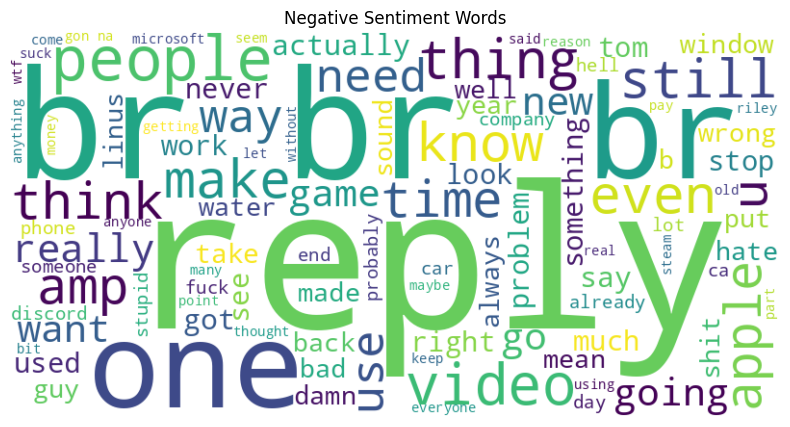

In [23]:
# Word cloud for negative sentiment
generate_word_cloud(data, label=0, title="Negative Sentiment Words")


In [27]:
import numpy as np
from tensorflow.keras.models import load_model
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = load_model('/content/LSTM_best_model.keras')
def preprocess_user_input(text, tokenizer, max_len=100):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    processed_text = ' '.join(tokens)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

user_input = input("Enter a comment to analyze sentiment: ")
processed_input = preprocess_user_input(user_input, tokenizer)
prediction = model.predict(processed_input)
sentiment = "Positive" if prediction >= 0.5 else "Negative"
print(f"Predicted Sentiment: {sentiment} (Confidence: {prediction[0][0]:.2f})")


Enter a comment to analyze sentiment: wash your clothes


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Predicted Sentiment: Positive (Confidence: 0.98)


751/751 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step


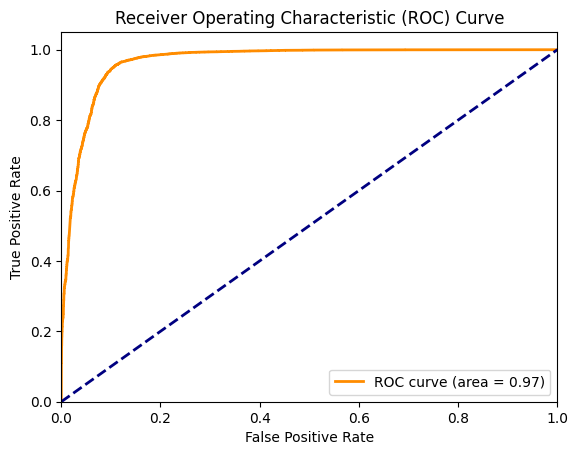

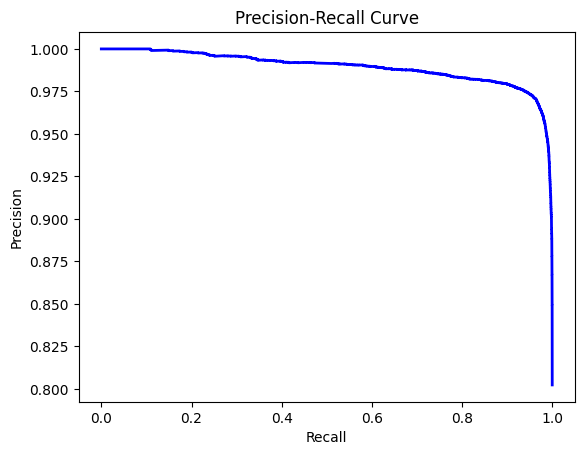

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 1. ROC Curve
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

